# Introduction

In many applications of data analysis, we are often interested in how long it takes before an event occurs, such as patient death in medicine, customer churn in business and equipment failure in engineering. Survival analysis is a well-established method to characterize the probability of time-dependent events occuring, and most importantly the contribution of various factors in modifying this probability.

In this series, we will put together a starter kit of essential concepts and tools for performing survival analysis. As survival analysis commonly used in analyzing customer churn patterns, we will use the Telco customer churn dataset available from IBM. In addition, as we have used this dataset as an example in demonstrating other analyses, such as [factor analysis for mixed data](https://kyso.io/nd823/famd/file/FAMD_part_3.ipynb), this provides a great opportunity for illustrating the need to use a diverse range of analytic approaches to generate balanced and confident insights from a dataset.

Let's get started!

# Import and pre-process data

After importing the data that has been cleaned and straightened out (see [previous post](https://kyso.io/nd823/data-prep)), we will first re-encode the outcome column "Churn" in binary form (0/1) as required by the packages. 

As survival analysis is **not** designed to characterize the probability of event occurrence in relation to a continuous variable, we need to bin the continuous variable `MonthlyCharges` into discrete levels, so that we can examine the probability of customer churn at different "tiers" of customer spending. The bin widths were chosen in light of the distribution of monthly charges seen in our [preliminary exploratory data analysis](https://kyso.io/nd823/exploratory-data-analysis/file/1.%20automated_EDA.ipynb) and [conditional density plot](https://kyso.io/nd823/exploratory-data-analysis/file/3.%20conditional_density_plot.ipynb). We will ignore `TotalCharges` as it is a composite of `MonthlyCharges` and `Tenure`.

In [138]:
## Import library
import pandas as pd
import numpy as np

## Import data
df = pd.read_csv("https://github.com/nchelaru/data-prep/raw/master/telco_cleaned_yes_no.csv")

## Encode "Churn" as 0/1, as required by lifelines package
df['Churn'] = df['Churn'].replace({'No':0, 'Yes':1})

## Discretize the continuous variable "MonthlyCharges", so it can be included in survival analysis
df['Binned_MonthlyCharges'] = pd.cut(x=df['MonthlyCharges'], 
                                     bins=[0, 30, 55, 70, 90, 110, 120], 
                                     labels=['$0-30', '$30-55', '$55-70', '$70-90', '$90-110', '$110-120'])
 
df['Binned_MonthlyCharges'] = df['Binned_MonthlyCharges'].astype('category')

# Kaplan-Meier estimates of survival function

At its core, survival analysis aims to estimate how much time it would take before a particular event happens. Data required for survival analysis is collected over a fixed-length observation period for a population of subjects, whether they be patients, customers or machinery, by noting 1) **whether** the event of interest occurs for each object, and if so, 2) **when** does it occur relative to the start of the observation period. 

These two parameters allow estimation of the __survival function__, which is one of the two key functions in survival analysis (the other is hazard function and will be covered in the next post). The survival function computes, at each time  *t*, the probability that the event of interest __does not__ happen. However, in reality, the actual survival function of a population cannot be observed. Instead, it is estimated by the non-parametric __Kaplan-Meier__ (KM) estimator, which essentially calculates the proportion of at-risk subjects that has not yet "succumbed" (to death, malfunction, etc) out of all at-risk subjects present at each time _t_.

The Python package `lifelines` and R package `survival` both provide easy implementations to plot the Kaplan-Meier survival curve from a dataset that contains (at least) the two parameters for each subject observed: whether the event of interest has occurred and if so, when did it occur relative to the start point of observation. For the Telco data set, this correspond to the `Churn` and `Tenure` columns, respectively.

## Using the Python package `lifelines`

The `lifelines` API is very similar to that of `scikit-learn`, where the `KaplanMeierFitter` object is first instantiated and then fitted to the data. 

Text(0, 0.5, 'Survival probability')

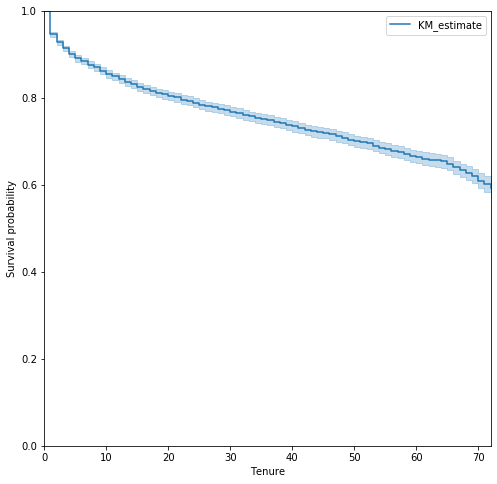

In [196]:
%matplotlib inline

## Import libraries
import matplotlib.pyplot as plt
from matplotlib import style
from lifelines import KaplanMeierFitter

## Set figure size
plt.rcParams['figure.figsize'] = [8, 8]

## Instantiate kmf object
kmf = KaplanMeierFitter()

## Fit kmf object to data
kmf.fit(df['Tenure'], event_observed = df['Churn'])

## Plot KM curve
ax = kmf.plot(ylim=(0, 1))
ax.set_xlabel("Tenure")
ax.set_ylabel("Survival probability")

We first created a KM curve for the entire dataset, where the y-axis represents the probability that a customer is still subscribed to the company's services at a given time (x-axis) since they first signed on. We see that the probability of a given customer leaving decreases (the curve flattens) with time, consistent with what we saw [previously](https://kyso.io/nd823/exploratory-data-analysis/file/3.%20conditional_density_plot.ipynb) showing that the probability of churn decreases as the customer tenure increases. The coloured band superimposed on the KM curve is the 95% confidence interval.

To prevent (or facilitate) the occurrence of the event of interest, we mostly want to know what factors in the observed population modify the survival probability. In our example, this means identifying which subset of customers, whether in terms of demographics or purchasing behaviour, are more or less likely to stop buying the company's services. To this end, we can plot and compare the KM survival curves for each level within each categorical variable:

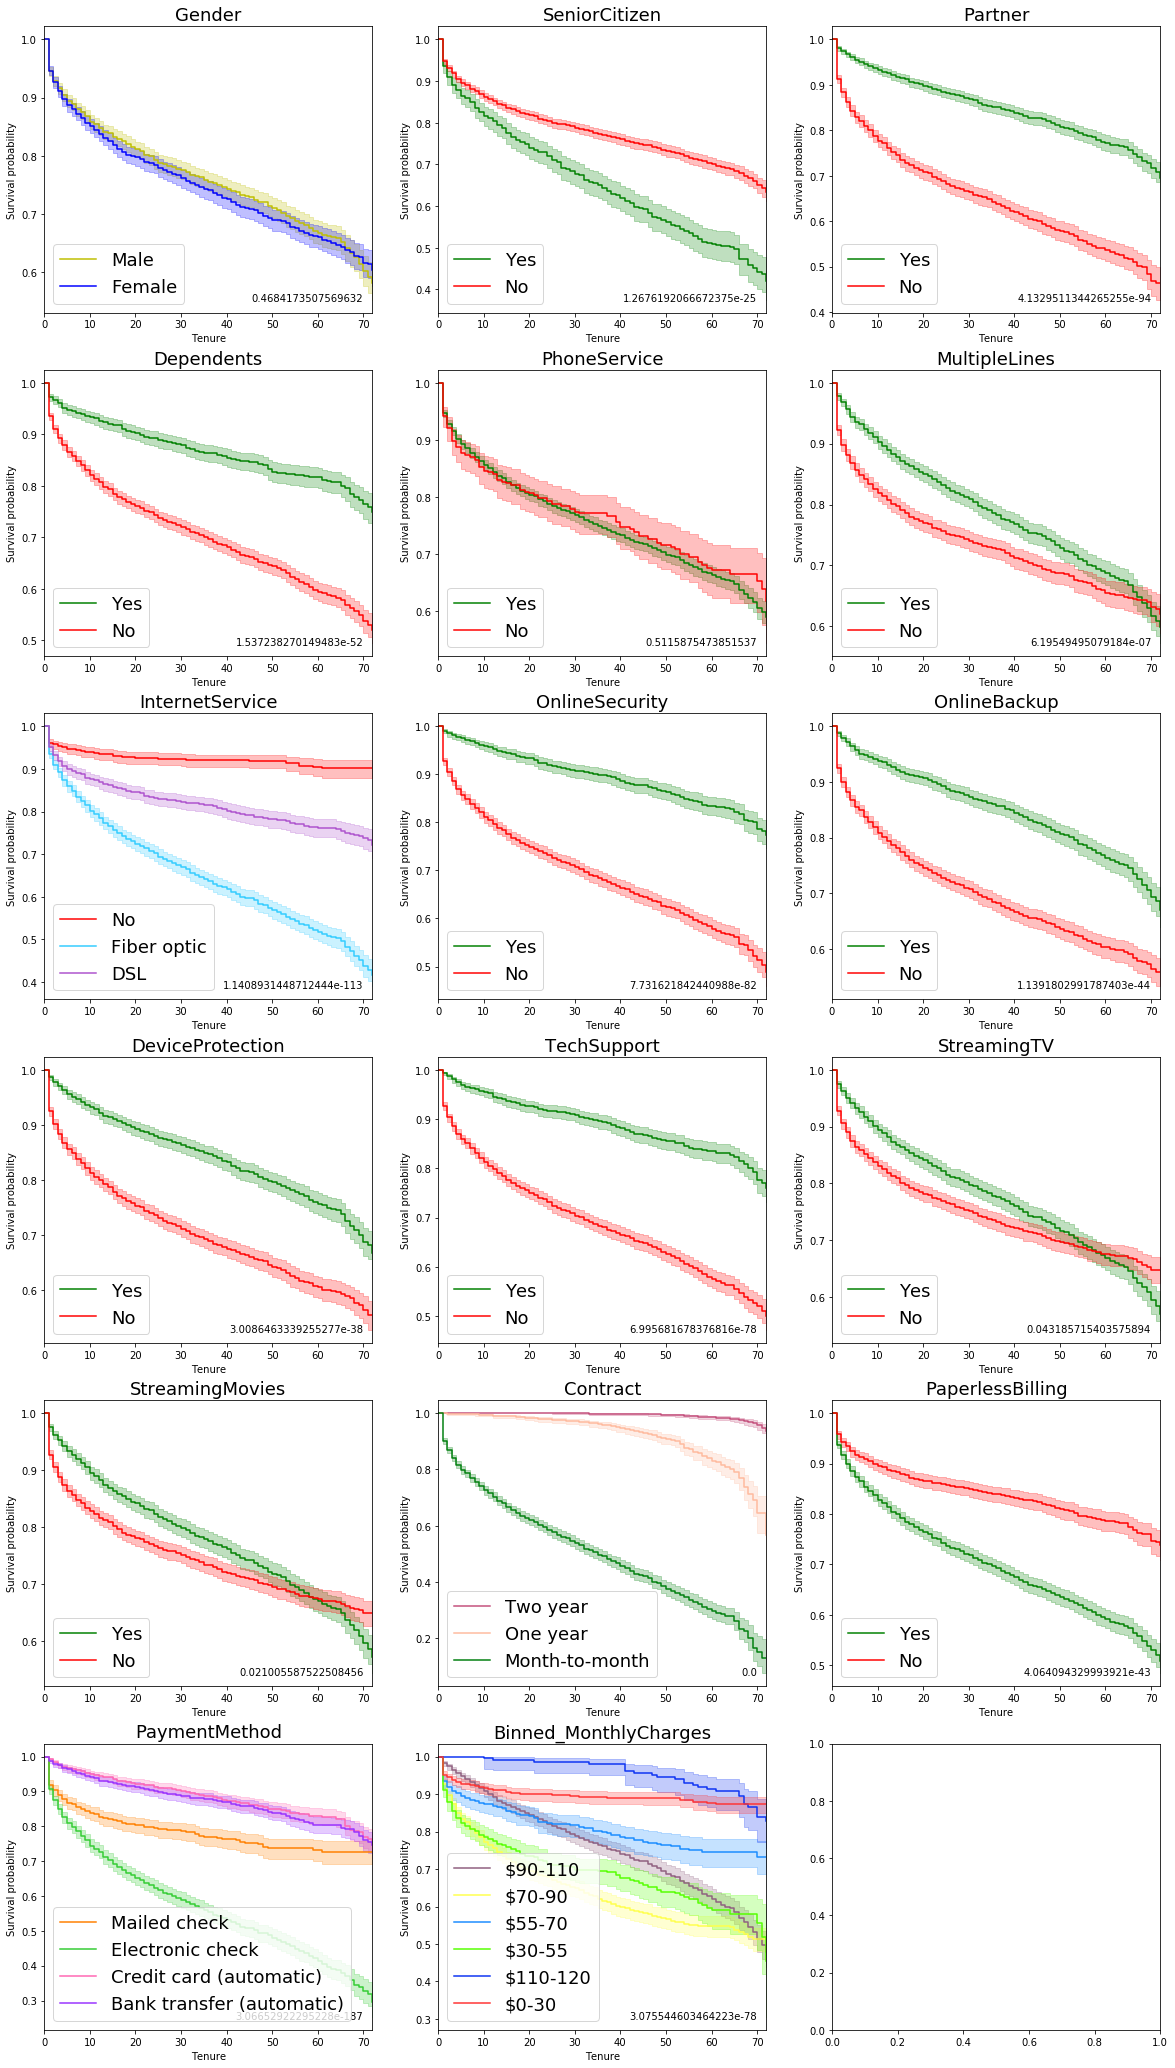

In [198]:
## Import libraries
from lifelines.statistics import multivariate_logrank_test
from matplotlib.offsetbox import AnchoredText

## Set colour dictionary for consistent colour coding of KM curves
colours = {'Yes':'g', 'No':'r',  
           'Female':'b', 'Male':'y', 
           'Month-to-month':'#007f0e', 'Two year':'#c4507c', 'One year':'#feba9e', 
           'DSL':'#ad53cd', 'Fiber optic':'#33ccff', 
           'Electronic check':'#33cc33', 'Mailed check':'#ff8000', 'Bank transfer (automatic)':'#9933ff', 'Credit card (automatic)':'#ff66b3',
           '$0-30':'#ff3333', '$30-55':'#55ff00', '$55-70':'#1a8cff', '$70-90':'#ffff4d', '$90-110':'#8f5f7f', '$110-120':'#0c32f3',
           '40-65m':'#d04813', '5-20m':'#97fa83', '20-40m':'#38ccde', '0-5m':'#6d8d97', '65-72m':'#a053b4'}
        
## Set up subplot grid
fig, axes = plt.subplots(nrows = 6, ncols = 3, 
                         sharex = False, sharey = False,
                         figsize=(20, 35))

## Plot KM curve for each categorical variable
def categorical_km_curves(feature, t='Tenure', event='Churn', df=df, ax=None):
    for cat in sorted(df[feature].unique(), reverse=True):
        idx = df[feature] == cat
        kmf = KaplanMeierFitter()
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat)
        kmf.plot(ax=ax, label=cat, ci_show=True, c=colours[cat])

col_list = df.drop(['Churn', 'Tenure', 'MonthlyCharges', 'TotalCharges'], axis=1).columns

for cat, ax in zip(col_list, axes.flatten()):
    categorical_km_curves(feature=cat, t='Tenure', event='Churn', df = df, ax=ax)
    ax.legend(loc='lower left', prop=dict(size=18))
    ax.set_title(cat, fontsize=18)
    p = multivariate_logrank_test(df['Tenure'], df[cat], df['Churn'])
    ax.add_artist(AnchoredText(p.p_value, loc=4, frameon=False))
    ax.set_xlabel('Tenure')
    ax.set_ylabel('Survival probability')
    
fig.subplots_adjust(top=0.92)

Now we see some interesting stuff! For each variable, the curve(s) that decline faster to 0% survival probability represent population subsets that are more likely to stop buying the company's services. For example, consistent with what we saw with [factor analysis of mixed data](https://kyso.io/nd823/famd) and [correlation analysis](https://kyso.io/nd823/exploratory-data-analysis/file/2.%20correlation_analysis_mixed_data.ipynb), customers with month-to-month contracts, fiber optic internet service and/or electronic check [sic] payment method are more likely than those without to churn. The `Binned_MonthlyCharges` group of curves also support findings from the [conditional probability density plot](https://kyso.io/nd823/exploratory-data-analysis/file/3.%20conditional_density_plot.ipynb), where customers at the two extremes of monthly fees are less likely churn than those in the middle of the range. Conversely, male and female customers have overlapping KM curves, and these two groups are shown to have similar rates of leaving the company. 

It must be noted that visual comparisons of the KM curves must be supplemented with statistical testing, which is the log-rank test in this case. The number at the bottom right corner of each subplot is the p-value result of the log-rank test for that group of comparisons. We see that all variables but `Gender` and `PhoneService` have significant differences in customer churn. However, log-rank test result is unreliable in cases where KM curves intersect, such as for `StreamingTV`, `StreamingMovies` and `Binned_MonthlyCharges`. We will cover this in more detail in future posts.

## Using the R package `survival`

The R package `survival` offers many of the same functionalities, which we will quickly demonstrate here:

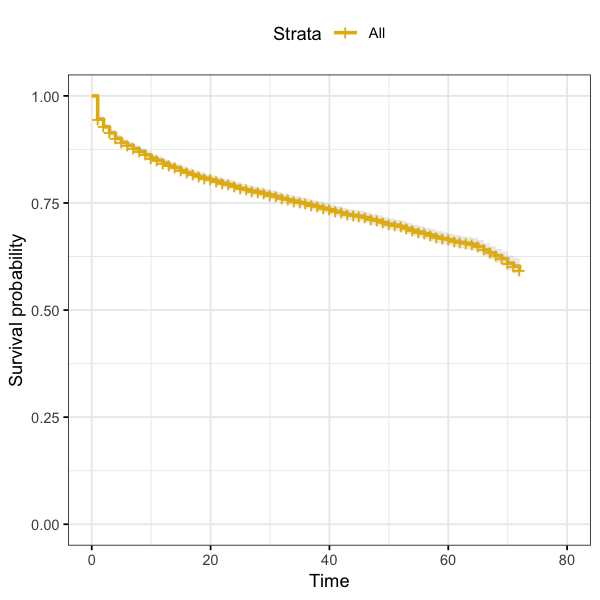

In [18]:
%get --from Python3 df

## Import libraries
library('survival')
library('survminer')

## Set figure size
options(repr.plot.width=5, repr.plot.height=5)

## Fit KM estimator to data
fit <- survfit(Surv(Tenure, Churn) ~ 1, data=df)

## Plot
ggsurvplot(fit, 
           conf.int = TRUE,
           ggtheme = theme_bw(),           
           palette = c("#E7B800", "#2E9FDF"))

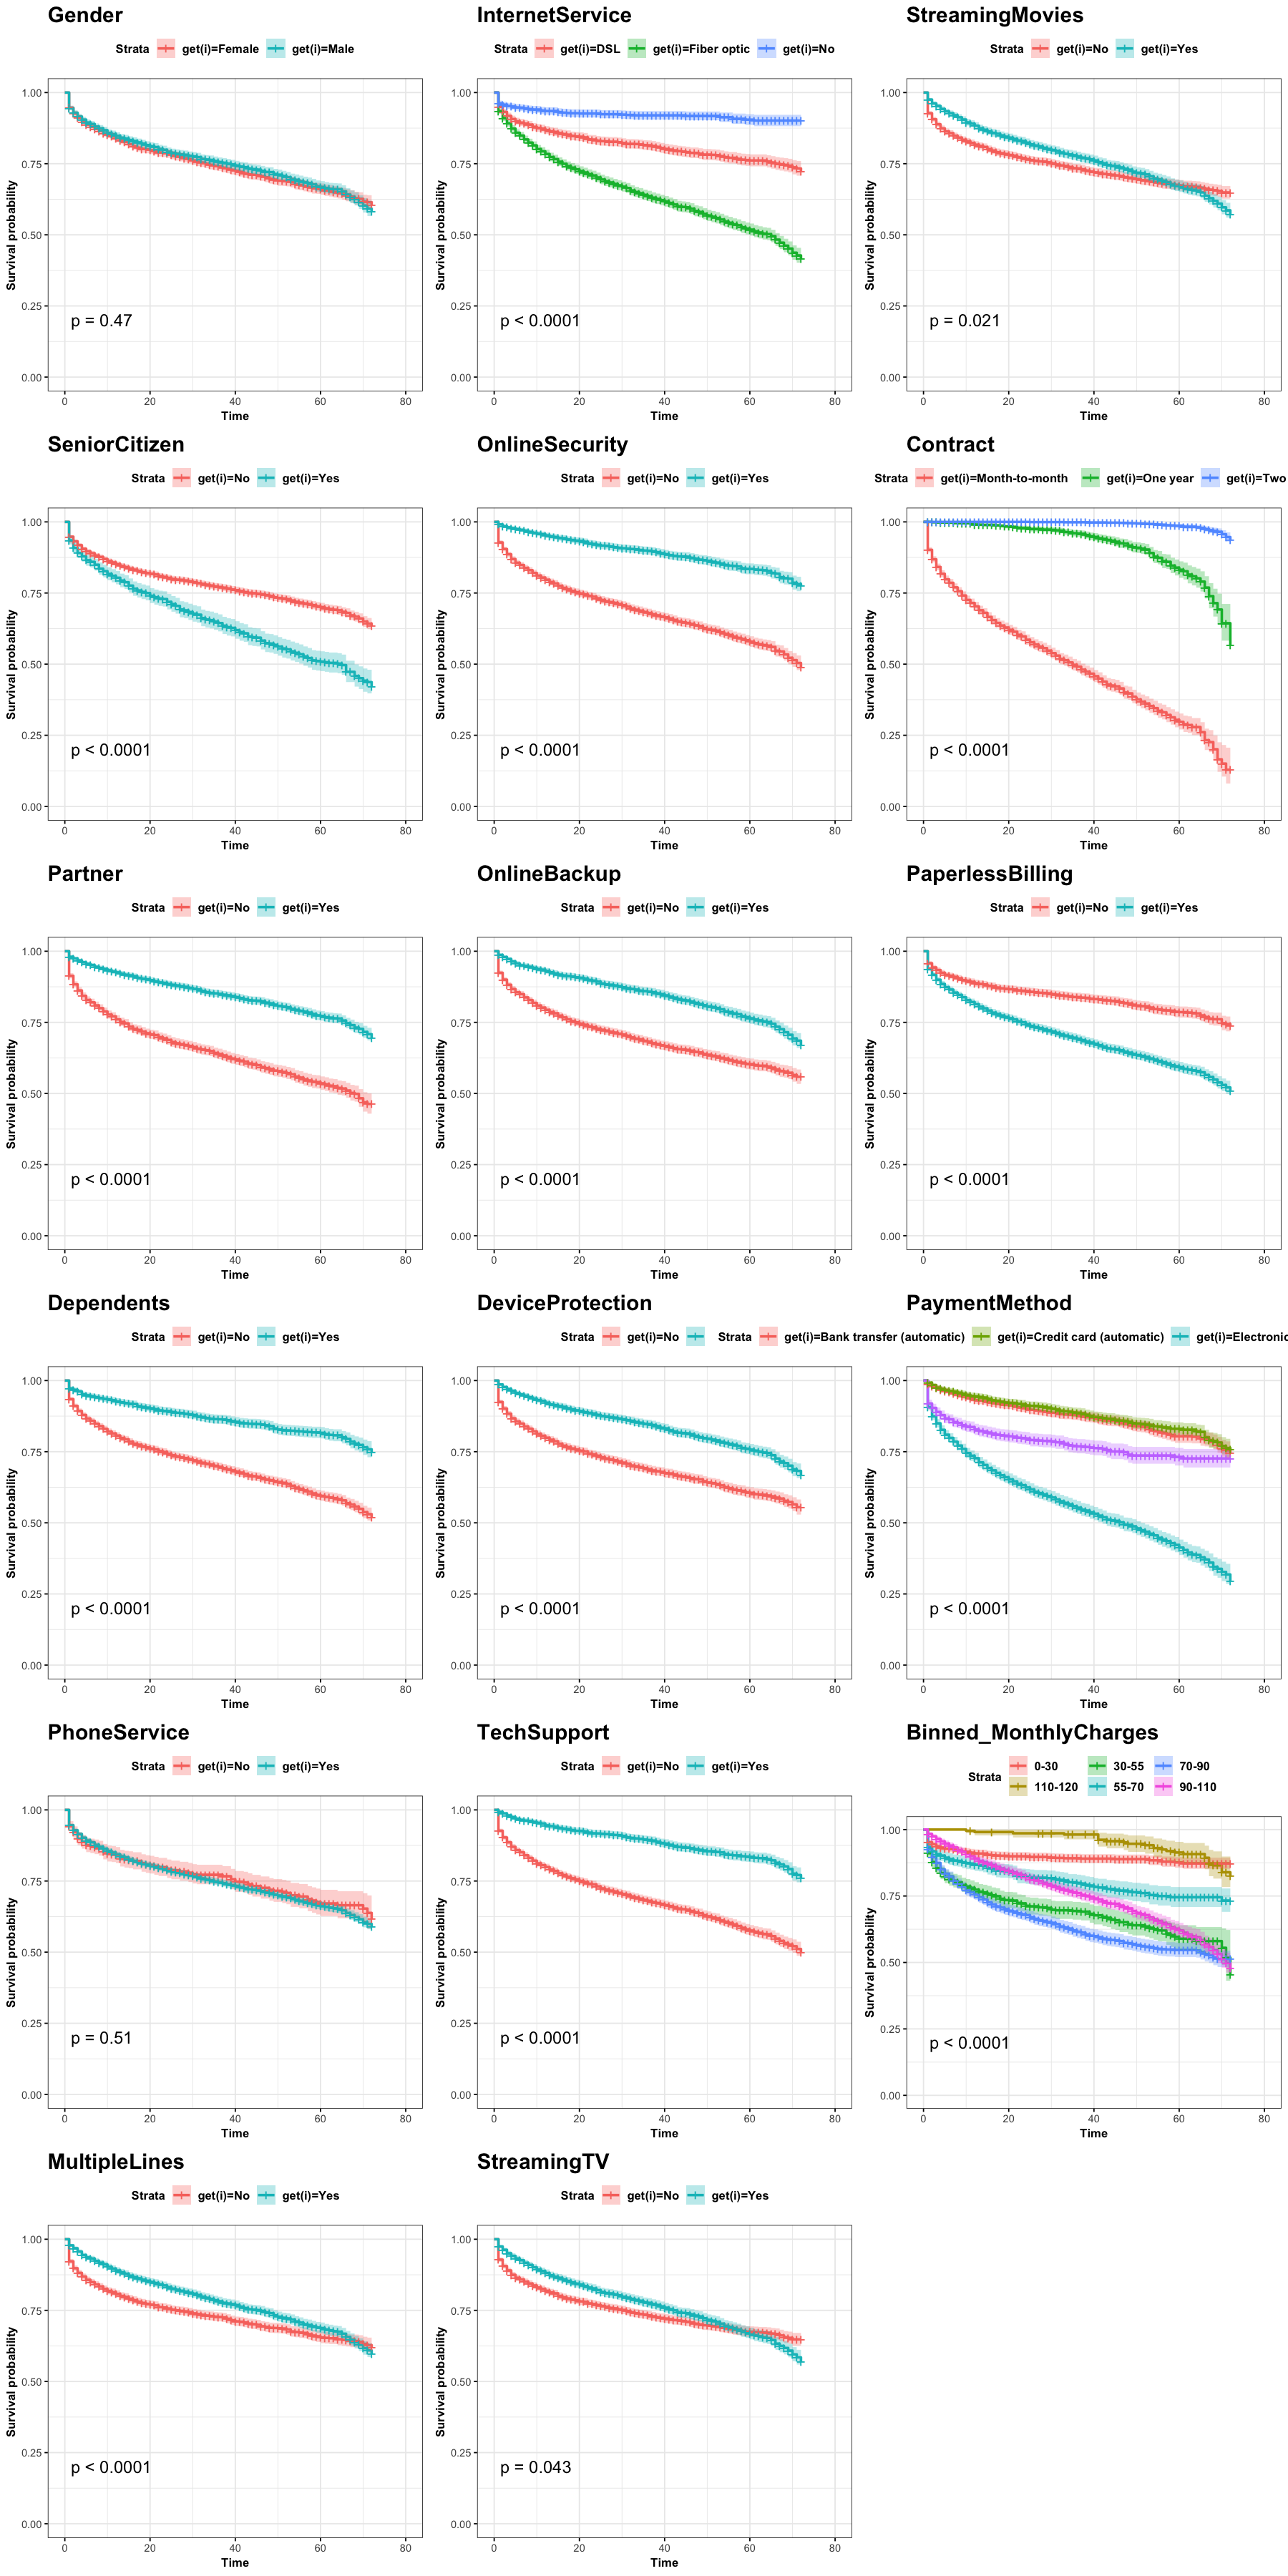

In [143]:
## Import library for allowing multiple subplots
library(gridExtra)

## Set subplot size
options(repr.plot.width=15, repr.plot.height=30)

## Drop columns containing continuous variables and the event variable "Churn"
subset_df <- within(df, rm("Churn", "Tenure", "MonthlyCharges", "TotalCharges"))

## For loop to create list of KM curve graph objects, one for each categorical variable
f <- 1

plot_list <- list()

for (i in colnames(subset_df)){
    x <- survfit(Surv(Tenure, Churn) ~ get(i), data=df)
    
    y <- ggsurvplot(x, 
                    conf.int = TRUE,
                    pval = TRUE, 
                    ggtheme = theme_bw(),  
                    font.main = c(18, "bold"),
                    font.x = c(10, "bold"), 
                    font.y = c(10, "bold"),
                    font.legend = c(10, "bold"),
                    ) + ggtitle(i)  
    
    plot_list[[i]] <- y
    
    f <- f + 1
}

## Create subplots
arrange_ggsurvplots(plot_list, 
                    print = TRUE, 
                    ncol = 3, 
                    nrow = 6)

This brings us to the end of part 1 of our series on survival analysis, which is already offering us interesting insights about our dataset. In the next four posts, we will delve deeper into other statistical and machine learning survival analysis models.

Please let feel free to leave any questions or comments below, any suggestions for improvements would be greatly appreciated!

Til next time! :)